# What's this?



This is part I of **Playmore: Executable Transcript of Andrej Karpathy’s _“[Neural Networks: Zero to Hero](https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)”_ Series**. Complete with timecodes.

Part I covers building **`micrograd`**, a minimal neural net training library. Along the way you build an intuition of how neural networks learn and work. It shows _how_ the code in [Andrej's lecture](https://www.youtube.com/watch?v=VMj-3S1tku0) evolves, one idea at a time, following the linear order of the video. There's deliberately almost no code encapsulation and [DRY principle](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself) is blatantly violated. This trade-off escapes the need to scroll up and down: all the relevant code is always in your sight.


<details style="margin-bottom:0.75rem;">
<summary><h3 style="display: inline;">But why?</h3></summary>
  
I started making these transcripts as a way to understand and review the material later. Then I realized this could be useful to others:
   
1. There's value in being able to follow the development of an idea through intuitions, trials and errors. It's a way of remembering the _why_ of how something works. Neat, polished, refactored final code doesn't do that. This notebook guides you through Andrej's intuitions that gradually lead to code without having to rewatch the video.
2. I find that reading commentary and executing code is way more efficient to revisit ideas after a while than going through the video again.
3. Some people like text more than video. Or want to supplement one with the other for a multimodal learning experience.


If you want the final code, then Andrej published it in [this Github repo](https://github.com/karpathy/micrograd).

</details>

<details style="margin-bottom:0.75rem;">
<summary><h3 style="display: inline;">Does this map 1:1 to the video?</h3></summary>


Not word-by-word. Occasionally there's some extra code or metaphor I added to illustrate a point. Some parts are (*manually*) summarized and you should refer to the video for details. 99% of the content comes from Andrej. Any mistakes or inaccuracies are all mine (_please let me know!_). 


</details>

<details style="margin-bottom:0.75rem;">
<summary><h3 style="display: inline;">How to take the most out of this?</h3></summary>

>
> **_What I cannot create, I do not understand._**
>
> [Richard Feynman](https://journals.biologists.com/jcs/article/130/18/2941/56386/What-I-cannot-create-I-do-not-understand)
>

This is a _play-as-you-watch_ lecture supplement. If the material is new, start by launching [the lecture](https://www.youtube.com/watch?v=VMj-3S1tku0). Use this notebook to test lecture ideas as they get developed and for a quick refresher after a while.

For maximum benefit, try to recreate the code for key ideas and write lecture notes of your own, aiming to express the underlying ideas precisely and poking holes in your reasoning.

</details>

<details style="margin-bottom:0.75rem;">
<summary><h3 style="display: inline;">Why <i>Playmore</i>?</h3></summary>

It's a reference to the _play_ button used to execute a `Jupyter` notebook cell. And a subtle invitation to learn by doing and playing, which is the most effective approach to master a subject. You don't learn to play tennis just by watching someone else do it - _gotta do it yourself!_

</details>

<details style="margin-bottom:0.75rem;">
<summary><h3 style="display: inline;">Who are you?</h3></summary>

I'm Andrey from [noneuclidianspace.com](https://noneuclidianspace.com), a programmer and fellow learner. Some 15 years ago I stumbled upon a yellow book titled _"Artificial Neural Networks"_ in a library by chance. I've been fascinated with AI ever since. I worked as a software architect, consultant, founder; built data aggregation systems and software that helps you become a better writer. Nowadays I'm thinking about how [Vannevar Bush's Memex](https://www.theatlantic.com/magazine/archive/1945/07/as-we-may-think/303881/) can be reimagined in the age of Transformer models. Reach out with ideas and feedback to **`playmore [at] noneuclidianspace.com`**.

</details>

<details style="margin-bottom:0.75rem;">
<summary><h3 style="display: inline;">License</h3></summary>

MIT License
</details>


# Intro [00:00:00](https://www.youtube.com/watch?v=VMj-3S1tku0)

In this tutorial you build a neural network from scratch, step-by-step. In the process you build an understanding of how it works and learns on an intuitive level. You end up with **[micrograd](https://github.com/karpathy/micrograd)** - a fully functional neural network training framework. It uses _backpropagation_, an algorithm applying derivatives to gently nudge neural network parameters towards values that minimize the prediction error. Backpropagation is a key part of any modern deep learning library, such as `PyTorch`, `Jax` and `Tensorflow`.

At its core, building a neural network is extremely simple. It's about 250 lines of code. All the complexity in modern neural net frameworks comes from efficiency and optimizing for time and space.

To follow this tutorial you only need basic knowledge of `Python` and vague recollection of calculus from high school.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# So what's a derivative? Let's build an intuition.

Derivative tells us how some function $f(x)$ changes if we plug in different numbers $x$. Does it go up? Does it go down? How fast? Derivative has the answer. Essentially, it is the slope of that function at $x$.

> _**History note**_: Using derivative as a tool for measuring rate of change was developed independently by famous mathematicians Isaac Newton and Gottfried Leibniz in the 17th century.
>
> Newton did this because he needed a tool for describing movement of bodies in the sky and on Earth, while Leibnitz was more concerned with pure mathematics and studied geometry of change. Newton came up with the idea first, but didn't rush to make it public. Meanwhile, Leibniz developed and published his own version of the concept. This led to a [lifelong rivalry](https://pages.cs.wisc.edu/~sastry/hs323/calculus.pdf) over attribution and one of the biggest scandals in science history.

### Derivative of a simple function with one input [00:08:08](https://www.youtube.com/watch?v=VMj-3S1tku0&t=488s)

Let's define a simple function with one variable:

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

This is just a randomly chosen function of one variable. In principle, you could pick another one, as long as it's _smooth_.

Now let's plot our $f(x)$ in the range $[-5;5]$ to get a feel of its shape.

In [4]:
xs = np.arange(-5, 5, 0.25) # a linear space made up of points between -5 and 5 with a step of 0.25
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

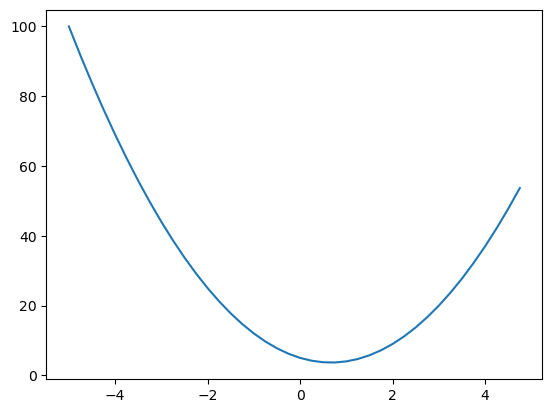

In [5]:
ys = f(xs)
plt.plot(xs, ys)

What is the derivative of any single point $x$ of this function? What does that even mean?

.

.

If you took a calculus class, you probably took a piece of paper, applied all the rules and got a mathematical expression of the derivative.

We are not going to do that. Noone in neural nets actually writes out an expression for the neural net. It's impractical - those nets are just _too_ big. Instead, we will focus on the intuition behind the derivative.

We already pointed out that the derivative gives you function slope at a point. But how do you actually measure slope at point $x$?

By introducing another point, $x+h$ spaced _very_ close to $x$. So close, that it's _almost_ the same point, _but not exactly_. As you move the second point closer to the first, the slope of the line connecting them (_secant_) becomes the slope of the _tangent line_ at
$x$. This means $h$ should be a very small value - _infinitely small_, ideally. However, for most practical purposes, _pretty small_ works just fine.

Armed with this idea, you find the slope at $x$ by computing the ratio $\large\frac{f(x+h)-f(x)}{h}$. Essentially, this gives you $\large\frac{rise}{run}$ over an incredibly small distance - so tiny that it's _nearly_ the same point.

Let's do it in code:

In [6]:
h = 0.00001 # small enough for us
x = 3.0
print(f"f(x+h)={f(x + h)}")
print(f"Here's how much change we caused by increasing x just a tiny bit -> " \
+f"{f(x + h) - f(x)}")
print(f"Here's the derivative value at x' = x+h -> " \
+f"{(f(x + h) - f(x))/h}")


f(x+h)=20.0001400003
Here's how much change we caused by increasing x just a tiny bit -> 0.0001400003000000538
Here's the derivative value at x' = x+h -> 14.00003000000538


As $h$ becomes closer to zero, our estimate of function slope at $x$ becomes more precise. There you go: these are the key intuitions that lead to [formal definition of the derivative using limits](https://en.wikipedia.org/wiki/Derivative).

At a certain point the slope becomes zero. That means we reached a minimum/maximum value, because the function stopped changing. For our specific function, this point is $x=2/3$

In [7]:
x = 2/3
print(f"f(x) value is about zero: {(f(x + h) - f(x))/h}")

f(x) value is about zero: 3.0000002482211127e-05


#### Derivative of a function with multiple inputs [00:14:12](https://www.youtube.com/watch?v=VMj-3S1tku0&t=852s)

Now let's take a little more complex case. We now have a function of three scalar inputs: `a`, `b`, and `c`.

In [8]:
h = 0.0001

def d(a,b,c):
  return a*b+c

# inputs
a = 2.0
b = -3.0
c = 10.0

What happens to our function $f(x) = a*b+c$, given $a = 2,\ b=-3,\ c= 10$ if we bump `a` a tiny bit?

.
.


Intuitively, this amplifies the negative component, `b`, so function value should go down. That would make the slope negative.

In [9]:
d1 = d(a, b, c)
d2 = d(a+h, b, c)

print(d1)
print(d2)
print(f"Slope: {(d2-d1)/h}")

4.0
3.999699999999999
Slope: -3.000000000010772


Now what if we bump `b` a tiny bit?

.
.

This would reduce the negative contribution to the function value, spelling a value increase. Then the slope of tangent line at that point would be positive.


In [10]:
d1 = d(a, b, c)
d2 = d(a, b+h, c)
print(f"Slope: {(d2-d1)/h}")


Slope: 2.0000000000042206


What would changing `c` do?

.
.

Plugging in the numbers mentally, we see that it should increase function value a bit. The change would be rather small, because we're just adding, not multiplying.

In [11]:
d1 = d(a, b, c)
d2 = d(a, b, c+h)
print(f"Slope: {(d2-d1)/h}")

Slope: 0.9999999999976694


_**Fun fact**_: We just learned the intuitions used by Isaac Newton and Gottfried Leibniz back in the 17th century. For more, take a look at _The Math Book: Big ideas simply explained, p. 268_.

## Great. But why was this important?

- You saw how the derivative gives you the direction and scale of change in function value, as we plug in different input values.

- As we'll see soon, that's one of the key things allowing neural nets to learn. They do so by gradually finding parameter values that nudge the _error function_ towards zero.  

- So far, we used functions of up to three parameters. Large neural networks use _billions_. But this key intuition remains the same.  

# Building the Value class

A neural network is essentially a mathematical expression. It takes in (1) input data and (2) parameters to output (3) predictions. We are now going to build the basic building block of such expression - the `Value` class.

#### Starting the core Value object of micrograd and its visualization [00:19:09](https://www.youtube.com/watch?v=VMj-3S1tku0&t=1149s)

`Value` is a simple scalar wrapper serving as an atom of our network.

In [12]:
class Value:

  def __init__(self, data, children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # node gradient with respect to the loss function
    self._prev = set(children)
    self._op = _op
    self.label = label

  # This works akin to object.ToString() in C#/Java
  def __repr__(self):
    return f"Value(data={self.data})"

  # lets us do a + b with Value objects
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  # lets us do a * b with Value objects
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out


  # tanh activation function
  def tanh(self):
    n = self.data
    tanh = (math.exp(2*n)-1)/(math.exp(2*n)+1)
    out = Value(tanh, (self,), _op='tanh')

    return out

Note how we can now perform arithmetic on `Value` objects and assign labels to each instance:

In [13]:
a = Value(2.0, label='a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label='c')

Under the hood `a + b` calls `Value.__add__`. Similarly `a*b` relies on `Value.__mul__`.

In [14]:
print(a+b)
print(a.__add__(b))
print(Value.__add__(a, b))

Value(data=-1.0)
Value(data=-1.0)
Value(data=-1.0)


Note how `Value` constructor accepts child node list as an argument:

```python
def __init__(self, data, children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # node gradient with respect to the loss function
    self._prev = set(children)
    self._op = _op
    self.label = label

```

This argument is set during arithmetic operations, such as `__add__`:

```python
  # lets us do a + b with Value objects
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out
```


This design lets us visualize `L` as a computation graph, showing how it evolved in a series of arithmetic operations with other `Value` objects. This is what we're doing next.


#### Visualizing the computation graph [24:58](https://youtu.be/VMj-3S1tku0?t=1498)

The slightly scarry visualization code below is not essential to the subject of this lecture (_but the plot it produces is!_). Basically, it takes a `Value` object, traverses all of its children and uses  `graphviz` open-source graph visualization library to plot the nodes and operations.


In [15]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in sorted(nodes, key=lambda x:x.label):
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

Time for some magic:

In [16]:
a = Value(2.0, label='a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

L

Value(data=-8.0)

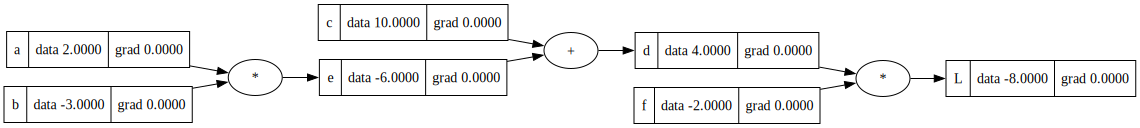

In [17]:
draw_dot(L)

> **Implementation note:** This code uses round "fake graph nodes" to display operations like `add` and `multiply`. The are not `Value` objects. The only real `Value` objects are the things in squares.

This graph gives us an intuition into what neural networks look like under the hood. They are massive mathematical expression trees that resemble this one on a huge scale.

### Interim recap [29:02](https://youtu.be/VMj-3S1tku0?t=1742)

Where we are so far:

- We are able to build out mathematical expressions using `+ and *`;
- We can do a single _forward pass_ through a mathematical expression, going from initial inputs all the way to the single output node `L`;
- We can visualize `L` as a computation graph.

Next, we are going to learn how to do _backpropagation_. This is an important step in training a neural net. It involves going through the computation graph backwards from `L`, figuring out the derivative of `L` with respect to every relevant _leaf node_. That gives you individual node contributions to `L`: do they cause its value to increase or decrease and how rapidly.

In neural net setting, output node `L` is typically referred to as the _loss function_, while other nodes may represent input data, trainable _weights_, or intermediate computations. Our goal is to gently nudge _trainable weights_ to a value that minimizes `L`, pushing it as close to zero as practically possible.

# Manual backpropagation example #1 [00:32:10](https://www.youtube.com/watch?v=VMj-3S1tku0&t=1930s)



Note how each `Value` node has a property called `grad`. It is there to hold the _gradient_ - the derivative of `L` with respect to that node.

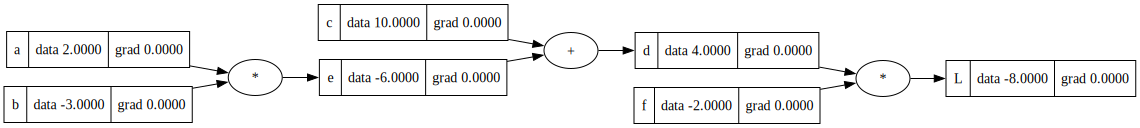

In [18]:
draw_dot(L)

We will now go through the entire computation graph backwards, starting with node **L** and setting individual gradients along the way.

What is the derivative of `L` with respect to `L`? In other words, if I change `L` by a tiny amount _h_, what is the impact of that change on `L`?

.

.

Intuitively, the impact is proportional and the derivative will be $1$. Now let's estimate that numerically:

In [19]:
# encapsulating into a function
# to avoid polluting the scope with scratchpad code.
def derivative_of_L():

  h = 0.00001 # a tiny distance

  a = Value(2.0, label='a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'

  L1 = L.data
  L2 = L.data + h

  print((L2-L1)/h) # rise/run = rate of change

derivative_of_L()


0.9999999999621422


No surprise: we see that $dL$ is about $1$. So let's update our `L.grad` now:

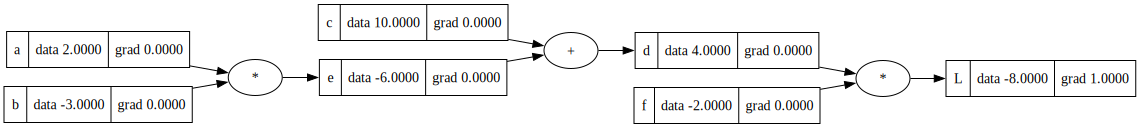

In [20]:
L.grad = 1.0
draw_dot(L)

### Computing the partial derivatives of `L` with respect to `d` and `f`  [34:40](https://youtu.be/VMj-3S1tku0?t=2081)

So how does changing `d` and `f` change `L`?

Let's start with `d`. We know that `L = d * f` and we want to know what is $dL/dd$. If you know your calculus, the analytic solution is $dL/dd = f$. But we don't have to believe that. Let's derive it.

1. By definition, a derivative can be computed as $f'(x) = \large\frac{(f(x + h) - f(x))}{h}$

2. Our `x` is `d * f`, so: $dL/dd = \large\frac{(d+h) * f) - d*f}{h}$.

3. Expanding that expression we get $dL/dd = \large\frac{d*f + h*f - d*f}{h}$ = $\large\frac{h*f}{h}$ = $f$.

4. By symmetry, $dL/df = d$.

Let's update the graph.

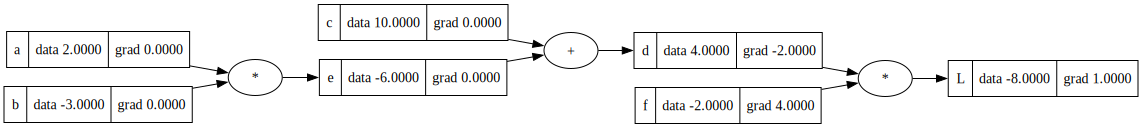

In [21]:
d.grad = f.data
f.grad = d.data
draw_dot(L)

Is this correct? Let's double check.

In [22]:
# encapsulating into a function
# to avoid polluting the scope with scratchpad code.
def dL_by_df():

  h = 0.00001

  a = Value(2.0, label='a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  f = Value(-2.0 + h, label='f')
  L = d * f; L.label = 'L'

  L2 = L.data

  print((L2-L1)/h)

dL_by_df()

4.000000000026205


In [23]:
def dL_by_dd():

  h = 0.0001

  a = Value(2.0, label='a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd';
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  d.data += h
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'

  L2 = L.data

  print((L2-L1)/h)

dL_by_dd()

-1.9999999999953388


### **The Crux of Backpropagation**: computing the partial derivatives of `L` with respect to `c` and `e` [38:09](https://youtu.be/VMj-3S1tku0?t=2289)




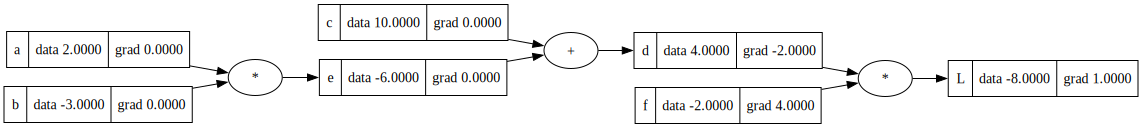

In [24]:
draw_dot(L)

> **Alert:** This will be the most important node to understand. If you understand the gradient for this node, you understand all of backpropagation.

Take another look at the graph. How sensitive is `L` to `c`? I.e. if we wiggle `c`, how much does this change `L` through `d`?

We already know how `c` impacts `d` and how `d` impacts `L`. Intuitively, there should be a way to plug these facts together to figure out the impact of `c`. In fact, there _is_ such a way.

Let's start with figuring out the value of `dd/dc`. In other words, how much `c` impacts `d`.

- By definition, a derivative can be computed as $f'(x) = \large\frac{f(x + h) - f(x))}{h}$

- Our `x` equals `c + e`, so: `dd/dc` = $\large\frac{(c+h) + e) - (c+e)}{h}$.

- Expanding that expression we get `dd/dc` = $\large\frac{h}{h}=1$.

- By symmetry, `dd/de` is also `1`.


But is that _really_ correct? Let's once again verify numerically:

In [25]:
# encapsulating into a function
# to avoid polluting the scope with scratchpad code.
def dd_by_dc():

  h = 0.00001
  a = Value(2.0, label='a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  d1 = d.data

  c = Value(10.0 + h, label='c')
  d = e + c; d.label = 'd'

  d2 = d.data

  print((d2-d1)/h)

dd_by_dc()

0.9999999999621422


That looks about right. We now know `dd/dc` and `dL/dd`. These are the _local_ derivatives that we want to tie together with the output of this graph. How do we put them together to figure out the impact of `c` and `d` on `L`, i.e. `dL/dc` and `dL/dd`?

.

.


_And the answer is_: The chain rule from calculus. Have a look at the Wikipedia [chain rule article](https://en.wikipedia.org/wiki/Chain_rule) for a refresher:

> If a variable $z$ depends on the variable $y$, which itself depends on the variable $x$ (that is, $y$ and $z$ are dependent variables), then $z$ depends on $x$ as well, via the intermediate variable $y$. In this case, the chain rule is expressed as:
>
> $\displaystyle {\frac {dz}{dx}}={\frac {dz}{dy}}\cdot {\frac {dy}{dx}}$

Intuitively, the chain rule states that knowing the instantaneous rate of change of $z$ relative to $y$ and that of $y$ relative to $x$ allows one to calculate the instantaneous rate of change of $z$ relative to $x$ as the product of the two rates of change:

> As put by George F. Simmons: _"If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."_

What this basically tells us is that we multiply connected rates of change, _chaining them together_. So:

- $\large\frac{dL}{dc} = \frac{dL}{dd} * \frac{dd}{dc} = -2 * 1 = -2$

- By symmetry, $\large\frac{dL}{de} = \frac{dL}{dd} * \frac{dd}{de} = -2 * 1 = -2$

Is that right? Once again, lets verify this numerically:


In [26]:
# encapsulating into a function
# to avoid polluting the scope with scratchpad code.
def dL_by_dc():

  h = 0.00001
  a = Value(2.0, label='a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  c = Value(10.0 + h, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'

  L2 = L.data

  print((L2-L1)/h)

dL_by_dc()

-1.9999999999242843


Intuition: the plus node of the graph simply routes the gradient as-is, since a derivative of a sum expression is just `1.0`.

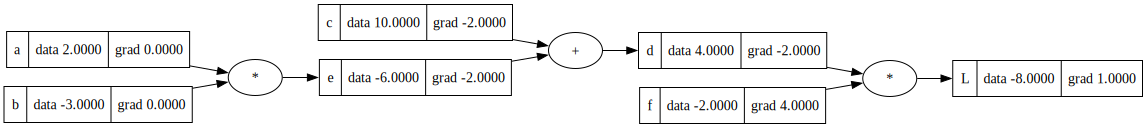

In [27]:
c.grad = -2.0 * 1.0
e.grad = -2.0 * 1.0
draw_dot(L)

In our case, the distance between the _local derivative_ and computation graph output `L` is just one step. In general, this distance can be massive, but same _chaining_ idea applies.

### Computing the partial derivatives of `L` with respect to `a` and `b` [47:10](https://youtu.be/VMj-3S1tku0?t=2832)

Now we are going to take another step back to figure out how `a` and `b` affect `L`.

Let's start with `a`. Thanks to the chain rule, we only need to multiply `de/da` by `dL/de` to figure out the impact of `a`. And then apply the same principle to `b`. Let's formulate what we know and what we want:

*KNOW*:
- `dd/de = -2.0`
- `de/da = b = -3.0 (multiplication rule from calculus. We derived it for L above.`

*WANT*:
- `dL/da = dd/de * de/da = -2.0 * -3.0 = 6.0 (chain rule)`

Are we right? Numerical verification time:

In [28]:
# encapsulating into a function
# to avoid polluting the scope with scratchpad code.
def dL_by_da():

  h = 0.00001
  a = Value(2.0, label='a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0 + h, label = 'a')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'

  L2 = L.data

  print((L2-L1)/h)

dL_by_da()

6.000000000128124


To obtain `dL/db`, we apply the same principle:

*KNOW*:
- `dd/de = -2.0`
- `de/db = a = 2.0 (multiplication rule from calculus. We derived it for L above.`

*WANT*:
- `dL/db = dd/de * de/db = -2.0 * 2.0 = -4.0 (chain rule)`

In [29]:
# encapsulating into a function
# to avoid polluting the scope with scratchpad code.
def dL_by_db():

  h = 0.00001
  a = Value(2.0, label='a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  b = Value(-3.0 + h, label = 'b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'

  L2 = L.data

  print((L2-L1)/h)

dL_by_db()

-4.000000000026205


We can now update the graph:

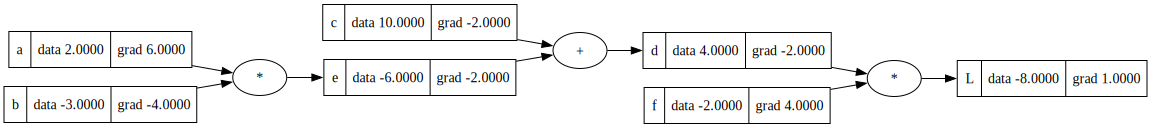

In [30]:
a.grad = 6.0
b.grad = -4.0
draw_dot(L)

That's it. We did manual backpropagation through the graph, step-by-step, applying the derivative chain rule from calculus. This is the essence of backpropagation: it's the recursive application of the chain rule through the computation graph, starting from the final output node.

# Preview of a single optimization step [00:51:11](https://youtu.be/VMj-3S1tku0?t=3071)

So how do we use gradient values in practice?

.

.


Say, our goal is to make `L` go up. Then at each optimization step we will use the gradient values to nudge `L` in the direction of the gradient by a small amount, called _learning rate_. This involves updating the individual leaf nodes of the computational graph.

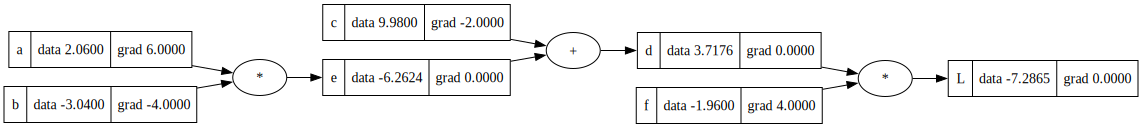

In [31]:
learning_rate = 0.01

a.data += learning_rate * a.grad
b.data += learning_rate * b.grad
c.data += learning_rate * c.grad
f.data += learning_rate * f.grad

e = a * b; e.label = 'e'
d = c + e; d.label = 'd'
L = d * f; L.label = 'L'

draw_dot(L)


# Manual backpropagation example #2: a neuron [00:52:52](https://youtu.be/VMj-3S1tku0?t=3182)

Let's take a look at a simplified neuron model, as taught in _Stanford CS231n_. We are going to backpropagate through a _neuron_. Biological neurons are complicated devices and what we have here is a very simple mathematical model losely based on a neuron - _perceptron_.

In [32]:
from IPython.display import Image
Image(url='https://cs231n.github.io/assets/nn1/neuron_model.jpeg')

What basically happens in a neural network is that we:

1. feed in a bunch of inputs _x(i)_,
2. multiply each input by its corresponding weight _w(i)_;
3. Sum all the input-weight products and add a _bias_ term _b_
4. Feed that through an activation function

> - Weights _w_ are like _synaptic strength_ for each input;

> - The _bias_ term _b_ can be viewed as a _happiness_ term. It makes a neuron less or more excited, regardless of the input value. Everyday analogy: Optimists sometimes can exaggerate even the smallest good news, while pessimists are prone to catastrophisizing insignificant events.

> - The activation function squashes neuron output to a narrower range. That's useful for numerical stability during optimization.

Out of the neuron comes the activation function applied to the dot product of the weights and inputs. That's all there is to it.

Let's take a look at one popular activation function, the `tanh`:

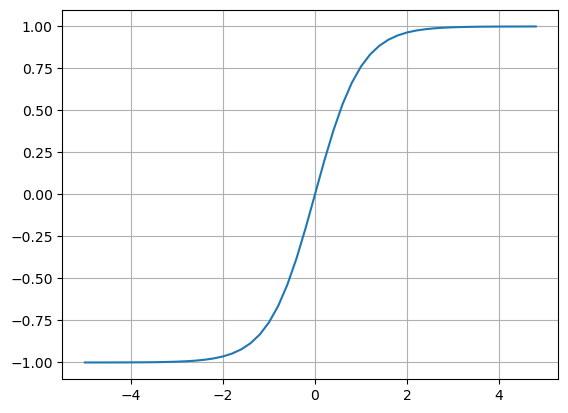

In [33]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5,5,0.2)));
plt.grid();

We see that `tanh` basically squashes `y(x)` to the range `[-1;1]`: If we input a very large value, `tanh` will cap it at one and very small values will be capped at `-1`.

#### Defining a toy neural net [55:20](https://youtu.be/VMj-3S1tku0?t=3320)

We take two inputs `x1` and `x2`, two corresponding weights, a bias term and `tanh` as the activation function.

In [34]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.7, label='b')

# Forward pass: multiply inputs and weights, add bias.
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'

This gives us the raw activation values without the activation function. We can now plot this mathematical expression:

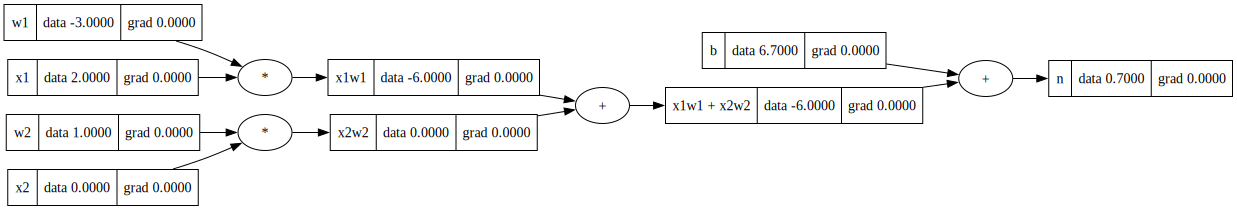

In [35]:
draw_dot(n)

We'll also need to implement the `tanh` activation function. There are several ways to compute it (look up on Wikipedia), we're going to use the exponentiation-based one and put it into our `Value` class:

```python
def tanh(self):
  n = self.data
  tanh = (math.exp(2*n)-1)/(math.exp(2*n)+1)
  out = Value(tanh, (self,), label='tanh')

  return out
```

Note that exponentiation is baked into `tanh` and not implemented as an atomic `Value` function. That's a deliberate design choice: we can pick the granularity we like, as long as we know how to backpropagate through the operation (_we'll get into that shortly!_).

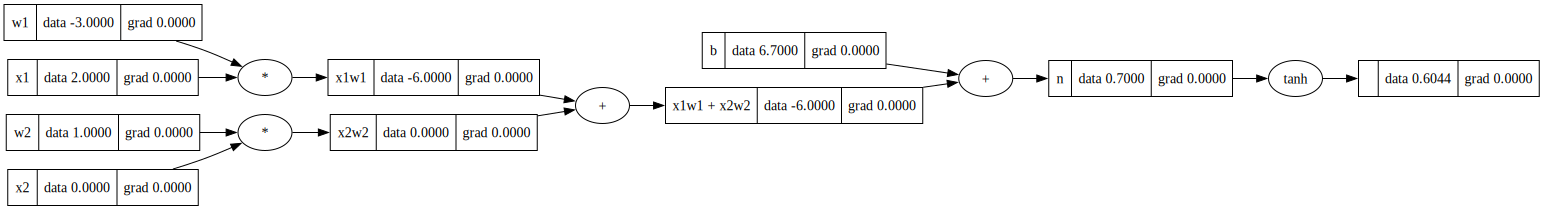

In [36]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.7, label='b')

# Forward pass: multiply inputs and weights, add bias.
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
# activation function
o = n.tanh();

draw_dot(o)

Now let's have a look at `tanh` squashing things. What happens if we set `b` to a large value?

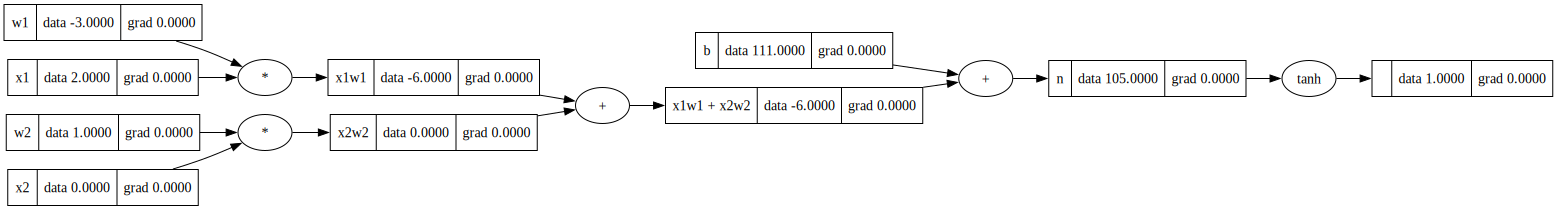

In [37]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(111, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh();
draw_dot(o)

Although raw neuron output is huge at `101`, `tanh` squashes it to `1`, thus capping neuron _excitement_.

#### Manual backpropagation [01:01:04](https://youtu.be/VMj-3S1tku0?t=3662)

Resetting `b` to 6.8813735870195432 as Andrey promised it will give us nice numbers. ¯\_(ツ)_/¯

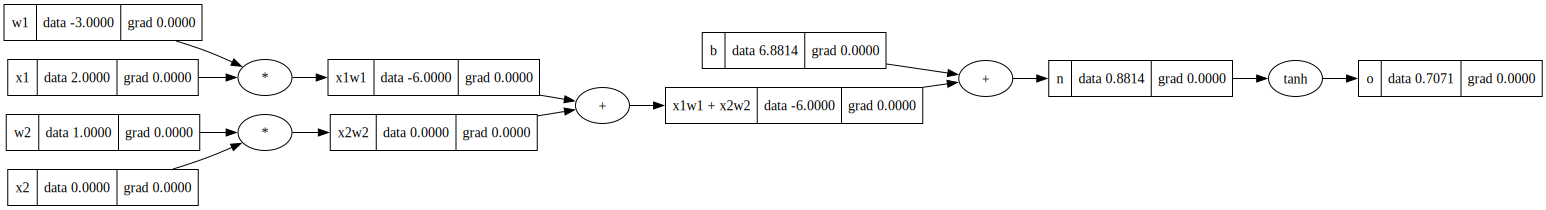

In [38]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o' # 'o' is short for 'output' here
draw_dot(o)

Now we are going to go through all the nodes starting with `o` and fill all the gradients. A real-life neural network would be huge and you can think of the neuron here as of a small piece of a large puzzle. We would be most interested in figuring out how weight values $w_i$ affect output and would tweak them to make output as small as we can.

First, we compute the derivative of `o` with respect to itself. As we know from before, this is always `1`.

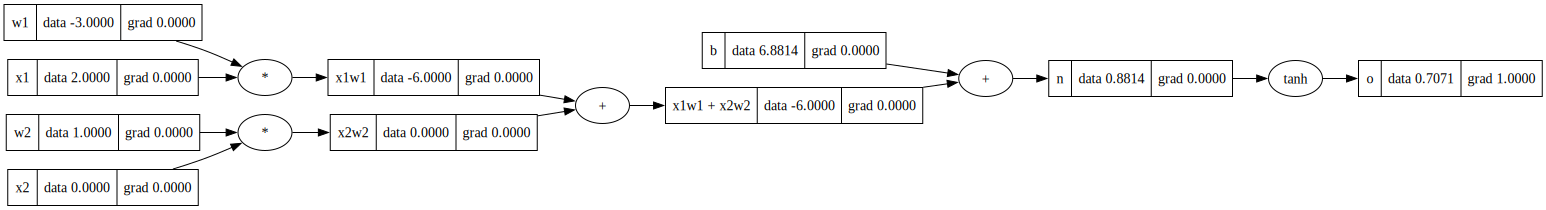

In [39]:
o.grad = 1.0
draw_dot(o)

To figure out how much `n` impacts `o`, we compute `do/dn`. Wikipedia tells us that one way to compute the derivative of `tanh(x)` is $1-tanh(x)^2$. Applying that to our case:



In [40]:
n.grad = 1.0 - o.data**2

In [41]:
n.grad

0.4999999999999999

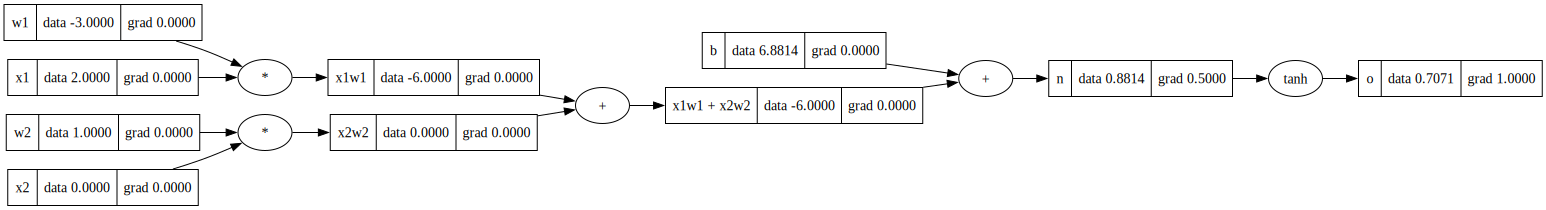

In [42]:
draw_dot(o)

Going one step back, we have a plus node. From our first backpropagation example, we know that gradient just flows through the plus node as-is. Thus:

In [43]:
x1w1x2w2.grad = 1.0 * n.grad
b.grad = 1.0 * n.grad

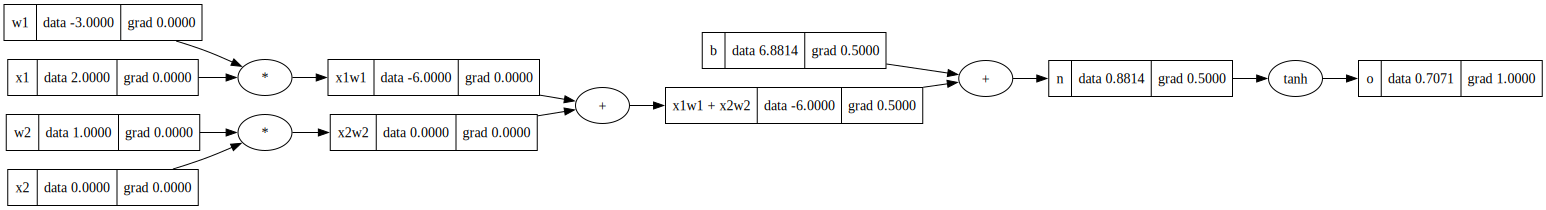

In [44]:
draw_dot(o)

Next, we've got yet another plus node and the same principle applies:

In [45]:
x2w2.grad = 1.0 * x1w1x2w2.grad
x1w1.grad = 1.0 * x1w1x2w2.grad

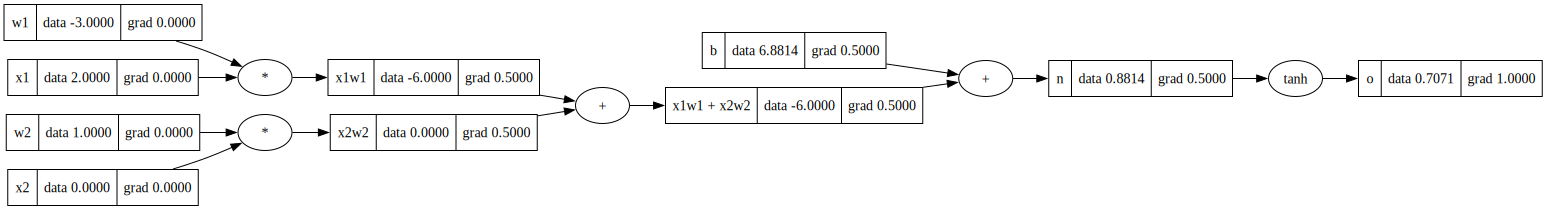

In [46]:
draw_dot(o)

Finally, we arrived at two multiplication nodes feeding weights and raw data into the network. From our first manual backprop example we know that the local derivative of a _times_ node is _the other term_. Hence:

In [47]:
x2.grad = w2.data * x2w2.grad # local piece of chain rule
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

We're done: we've backpropagated through the entire graph. Let's redraw:

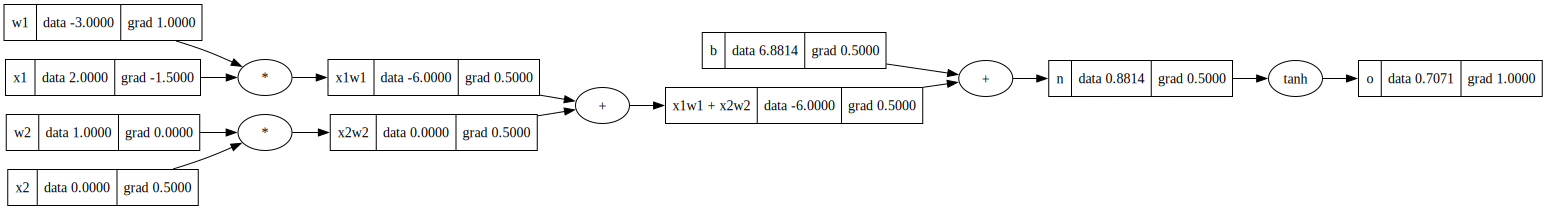

In [48]:
draw_dot(o)

# Automating backpropagation

Doing backprop by hand is obviously suboptimal once we've learned how it works. Let's update our `Value` class so that it backpropagates automatically.

## Implementing the backward function for each operation [01:09:02](https://youtu.be/VMj-3S1tku0?t=4142)

Since the exact mechanics of computing a local gradient depend on the operation, we'll redefine the `add`/`mul`/`tanh` methods to apply the right kind of logic on the `Value` instance. All the logic directly follows from the calculus rules we used when doing backpropagation manually.

The newly introduced `_backward` function will specify how to chain the outputs gradients into the inputs gradients. By default it does nothing. However, if the `Value` object is being created through a mathematical operation, specifics of applying the local chain rule will be passed along:



In [49]:
class Value:

  def __init__(self, data, children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # node gradient with respect to the loss function
    self._backward = lambda: None # the backpropagation delegate
    self._prev = set(children)
    self._op = _op
    self.label = label

  # This works akin to object.ToString() in C#
  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad

    out._backward = _backward
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):
    n = self.data
    tanh = (math.exp(2*n)-1)/(math.exp(2*n)+1)
    out = Value(tanh, (self,), label='tanh')
    def _backward():
      local_derivative = (1-tanh**2)
      self.grad = local_derivative * out.grad

    out._backward = _backward
    return out

In [50]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh();


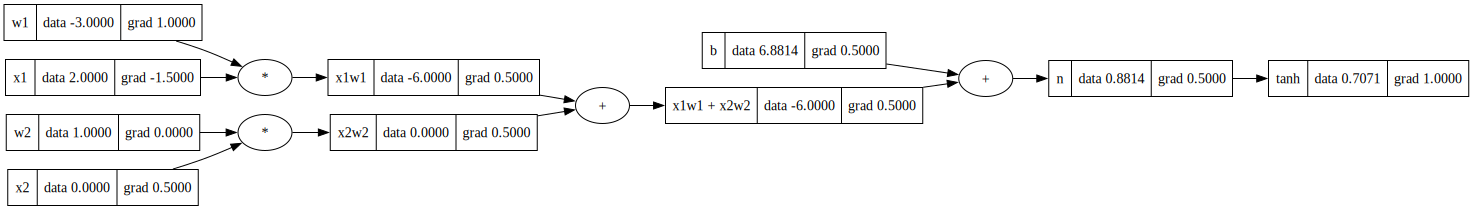

In [51]:
o.grad = 1.0
nodes = [o,n,b,x1w1x2w2,x1w1,x2w2]
for node in nodes:
  node._backward()

draw_dot(o)

## Implementing the backward function for a whole expression graph [01:17:32](https://www.youtube.com/watch?v=VMj-3S1tku0&t=4652s)

We implemented backpropagation for each individual node. However, calling the `_backward` method manually on each node isn't practical. Ideally, we want to do something like `o._backward` and have gradients automatically backpropagate all the way to the left of the graph.

A node is ready to backpropagate only once all of its descendants have their gradients computed. This means we need a way of ordering nodes. This problem is called _topological sorting_:

> Precisely, a _topological sort_ is a graph traversal in which each node $v$ is visited only after all its dependencies are visited. A topological ordering is possible if and only if the graph has no directed cycles, that is, if it is a _directed acyclic graph (DAG)_.
> \-- [Wikipedia](https://en.wikipedia.org/wiki/Topological_sorting#:~:text=Precisely%2C%20a%20topological%20sort%20is,directed%20acyclic%20graph%20(DAG))



Note how the code below recursively adds node children and only then the current node itself. This gives us a left-to-right list of our graph nodes.

In [52]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

build_topo(o)
topo

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

Now lets place this into our `Value` class. We're going to define a public `backward` method (note no underscore) with this logic.

In [53]:
class Value:

  def __init__(self, data, children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # node gradient with respect to the loss function
    self._backward = lambda: None # the backpropagation delegate
    self._prev = set(children)
    self._op = _op
    self.label = label

  # This works akin to object.ToString() in C#
  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad

    out._backward = _backward
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):
    n = self.data
    tanh = (math.exp(2*n)-1)/(math.exp(2*n)+1)
    out = Value(tanh, (self,), label='tanh')
    def _backward():
      local_derivative = (1-tanh**2)
      self.grad = local_derivative * out.grad

    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)
    # we need to go in reversed order - from right to left of the graph.
    topo = list(reversed(topo))

    self.grad = 1.0
    for node in topo:
      node._backward()

Now let's reset the graph:



In [54]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh();


And see if `backpropagate` works:


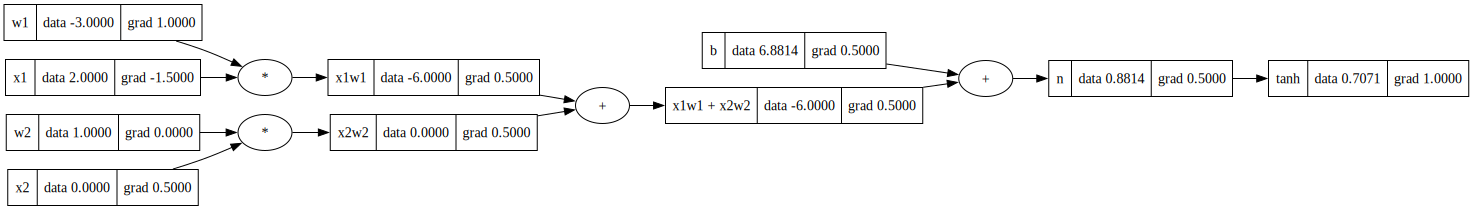

In [55]:
o.backward()
draw_dot(o)

## Fixing a backprop bug when one node is used multiple times [01:22:30](https://www.youtube.com/watch?v=VMj-3S1tku0&t=4952s)

There's a problem with our code. Any time a `Value` is used more than once, the gradient will be incorrect. Here's a demo:

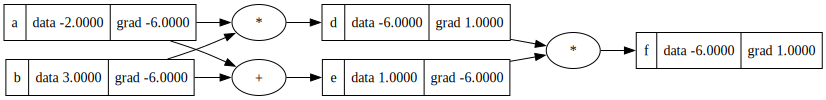

In [56]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')

d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)

Gradients of `a` and `b` are wrong, because they are being overwritten during backpropagation from `d` and `e`. How do we fix that?

.

.

.

The fix is to accumulate gradients instead of setting them:

In [57]:
class Value:

  def __init__(self, data, children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # node gradient with respect to the loss function
    self._backward = lambda: None # the backpropagation delegate
    self._prev = set(children)
    self._op = _op
    self.label = label

  # This works akin to object.ToString() in C#
  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      # gradient accumulation
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      # gradient accumulation
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):
    n = self.data
    tanh = (math.exp(2*n)-1)/(math.exp(2*n)+1)
    out = Value(tanh, (self,), label='tanh')
    def _backward():
      # gradient accumulation
      local_derivative += (1-tanh**2)
      self.grad = local_derivative * out.grad

    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)
    topo = list(reversed(topo))

    self.grad = 1.0
    for node in topo:
      node._backward()

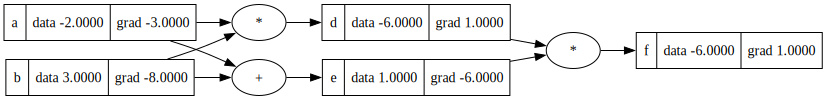

In [58]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)

#  Breaking up `tanh`, exercising with more operations [01:27:05](https://www.youtube.com/watch?v=VMj-3S1tku0&t=5225s)

Right now code like this won't work because of value conversion:

```
a = Value(1)
b = a + 2
```

To the interpreter this looks like adding two different types. It doesn't know how to do that, unless we state it.

Another case is reverse operand ordering:

```
a = Value(1)
b = 2 * a
```

In this case Python will attempt to call 2.`__mul__(a)` and will fail, since this type handling isn't implemented. To work around this, there's a built-in method called `__rmul__`, which is called as a backup whenever `__mul__` fails. `__rmul__` basically is a way to ask `a` if it knows how to multiply by 2.  

As a matter of convenience, let's improve implementation of arithmetic operations in our `Value` class to cover these cases.



In [59]:
class Value:

  def __init__(self, data, children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # node gradient with respect to the loss function
    self._backward = lambda: None # the backpropagation delegate
    self._prev = set(children)
    self._op = _op
    self.label = label

  # This works akin to object.ToString() in C#
  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      # gradient accumulation
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      # gradient accumulation
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def tanh(self):
    n = self.data
    tanh = (math.exp(2*n)-1)/(math.exp(2*n)+1)
    out = Value(tanh, (self,), label='tanh')
    def _backward():
      # gradient accumulation
      local_derivative = (1-tanh**2)
      self.grad += local_derivative * out.grad

    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)
    topo = list(reversed(topo))

    self.grad = 1.0
    for node in topo:
      node._backward()

Now let's implement exponentiation, complete with backpropagation:

In [60]:
class Value:

  def __init__(self, data, children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # node gradient with respect to the loss function
    self._backward = lambda: None # the backpropagation delegate
    self._prev = set(children)
    self._op = _op
    self.label = label

  # This works akin to object.ToString() in C#
  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      # gradient accumulation
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      # gradient accumulation
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def tanh(self):
    n = self.data
    tanh = (math.exp(2*n)-1)/(math.exp(2*n)+1)
    out = Value(tanh, (self,), label='tanh')
    def _backward():
      # gradient accumulation
      local_derivative += (1-tanh**2)
      self.grad = local_derivative * out.grad

    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      local_derivative = 1.0 if out.data == 0 else out.data
      self.grad += local_derivative * out.grad

    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)
    topo = list(reversed(topo))

    self.grad = 1.0
    for node in topo:
      node._backward()

In [61]:
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

Finally, let's have a look at implementing division. Consider the following case:

```
a = Value(2.0)
b = Value(4.0)
a / b # We want to get `0.5` as the result
```

One neat trick is to redefine division as multiplication:

```
a / b = a * 1/b = a * b^-1
```

This is useful because it reduces the amount of floating point rounding errors  when dealing with a large number of repetitive division calculations. Multiplication is also faster than division.

> Note: Modern compilers and interpreters can automatically rewrite division as multiplication if they deem that helpful. Therefore, it's not a silver bullet rule. In this specific case, it's a useful excercise. In general, profilers and benchmarks are your best friend for figuring out if this is worth doing.


We're going to implement division in three parts:

1. Use the `__truediv__` method to divide integers and floating point numbers by using multiplication and raising to negative power.

2. Implement the `pow` method to raise a given number to the power we want and have `__truediv__` call it.

3. Implement negation and substraction - we'll need them to compute the derivative of a power function.

> Note: When you use the division operator (/) between two objects, Python internally calls the `__truediv__` method of the left operand object and passes the right operand object as an argument. The `__truediv__` method should return the result of the division.

In [62]:
class Value:

  def __init__(self, data, children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # node gradient with respect to the loss function
    self._backward = lambda: None # the backpropagation delegate
    self._prev = set(children)
    self._op = _op
    self.label = label

  # This works akin to object.ToString() in C#
  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      # gradient accumulation
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      # gradient accumulation
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __pow__(self, other):
    assert isinstance(other, (int, float)),\
     "only supporting int/float powers for now"

    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * self.data ** (other-1) * out.grad

    out._backward = _backward
    return out

  def __truediv__(self, other):
    # When you use the division operator (/) between two objects,
    # Python internally calls the __truediv__ method
    # of the left operand object and passes the right operand
    # object as an argument.
    # The __truediv__ method should return the result of the division.
    return self * other**-1

  def tanh(self):
    n = self.data
    tanh = (math.exp(2*n)-1)/(math.exp(2*n)+1)
    out = Value(tanh, (self,), label='tanh')
    def _backward():
      # gradient accumulation
      local_derivative = 0.0
      local_derivative += (1-tanh**2)
      self.grad = local_derivative * out.grad

    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      local_derivative = 1.0 if out.data == 0 else out.data
      self.grad += local_derivative * out.grad

    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)
    topo = list(reversed(topo))

    self.grad = 1.0
    for node in topo:
      node._backward()

In [63]:
a = Value(2.0)
b = Value(4.0)

In [64]:
a / b

Value(data=0.5)

In [65]:
a - b

Value(data=-2.0)

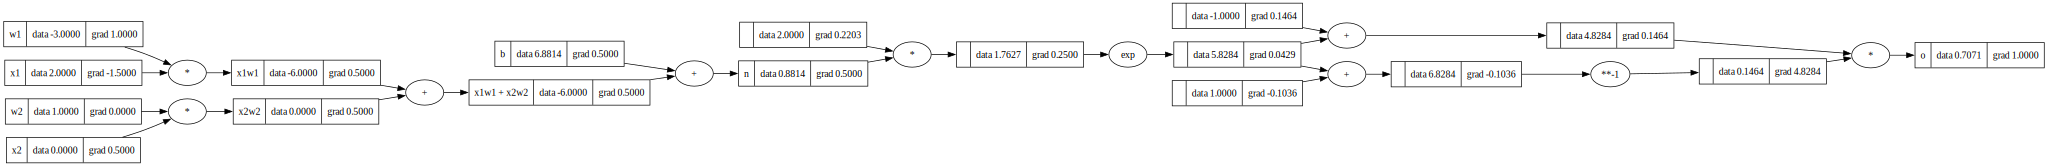

In [66]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# Redefine `tanh` through a mathematically equivalent
# combination of atomic mathematical operations we've just added.
# o = n.tanh()
# exp-based formula for `tanh` (see Wikipedia)
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()
draw_dot(o)


The takeaway of this chapter:  We saw how we could add and change operations and, as long as they're (a) mathematically equivalent and (b) implement the local backward/forward propagation pass correctly, this new logic is plugged into the graph automatically. The chain rule lets you focus on just one step at a time, no matter how complex the entire graph is.

The granularity level at which you implement operations is totally up to you. You can implement atomic or coarse operations, as with `tanh`. The only thing that matters is being able to correctly compute the local derivative and apply the chain rule from calculus.

# Doing the same thing but in PyTorch: comparison [01:39:31](https://www.youtube.com/watch?v=VMj-3S1tku0&t=5972s)

Now we'll see how to implement the same thing using `PyTorch` - a modern deep learning library that you would likely use in production. `micrograd` is roughly modeled after `PyTorch`.

PyTorch uses a `Tensor` type for representing data. Semantically it's similar to our `Value` type. However, `Tensor` is basically a multidimensional scalar array, while our `Value` class holds just one scalar number at a time.

Some subtleties to note:

1. PyTorch uses `float32` for scalar representation by default. If you'd like to represent scalars with double precision (like Python does by default), use `Tensor.double()`

2. PyTorch `Tensor` is much more efficient than our basic `Value` class and supports parallel calculations.

3. Gradient computation is off by default for efficiency reasons. To turn it on, you need to use `Tensor.requires_grad = True`

You can also take a look at how various operations are implemented in the [Tensor source code](https://github.com/pytorch/pytorch/blob/main/torch/_tensor.py)

Have a look at sample code below. It implements the same network we've built manually in PyTorch. The API is pretty much the same. And gradient computation yields the same results we obtained in previous steps.



In [67]:
import torch
torch.Tensor([2.0]).dtype

torch.float32

In [68]:


x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1:', x1.grad.item())
print('w1:', w1.grad.item())
print('x2:', x2.grad.item())
print('w2:', w2.grad.item())
print('b:', b.grad.item())

0.7071066904050358
---
x1: -1.5000003851533106
w1: 1.0000002567688737
x2: 0.5000001283844369
w2: 0.0
b: 0.5000001283844369


Note how `o` has a `backward` function, just like in our implementation of the `Value` class. We can pop out `grad` values too:

In [69]:
x1.grad.item()

-1.5000003851533106

`PyTorch` can do everything we implemented in the `Value` class and more. While `micrograd` handles a special case where the values are single scalar numbers, `PyTorch` works with n-dimensional tensors and is significantly more computationally efficient, allowing to run lots of operations in parallel.

# Building out a neural net library (multi-layer perceptron) in micrograd [01:43:55](https://www.youtube.com/watch?v=VMj-3S1tku0&t=6235s)

Next we'll build a neural net piece by piece. We'll end up with a two-layer _multi-layer perceptron (MLP)_. As mentioned, neural nets are just a specific class of mathematical expressions.


Let's start by implementing a single neuron.

In [70]:
from IPython.display import Image
Image(url='https://cs231n.github.io/assets/nn1/neuron_model.jpeg')

Note that the activation value will be different at each run, since we're initializing weights to random values.

In [71]:
import random

class Neuron:

  def __init__(self, nin):
    """
      nin: number of inputs
    """
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w * x + b
    # zip iterates over pairwise tuples obtained by pairing two sequences
    activation = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
    out = activation.tanh()

    return out

x = [2.0, 3.0]
n = Neuron(2)
n(x) #


Value(data=-0.8003185192553023)

Next, let's define a layer - basically, a logical group of individual neurons that are not connected to each other and evaluated independently.

In [72]:
class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    # as a matter of convenience, unwrap the value
    # out of array if it's just a single value.
    return outs[0] if len(outs) == 1 else outs

x = [2.0, 3.0]
n = Layer(2, 3)
n(x) #

[Value(data=0.9923519844982043),
 Value(data=0.09097914660393831),
 Value(data=0.9636236098798912)]

Finally, let's complete the picture and define an MLP. As the image below shows, an MLP is just a sequence of fully interconnected layers.

In [73]:
from IPython.display import Image
Image(url='https://cs231n.github.io/assets/nn1/neural_net2.jpeg')

In [74]:
class MLP:

  def __init__(self, nin, nouts):
    sizes = [nin] + nouts
    self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)

    return x

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)


Value(data=-0.07858165176637057)

Finally, we can draw the computational graph of our network.

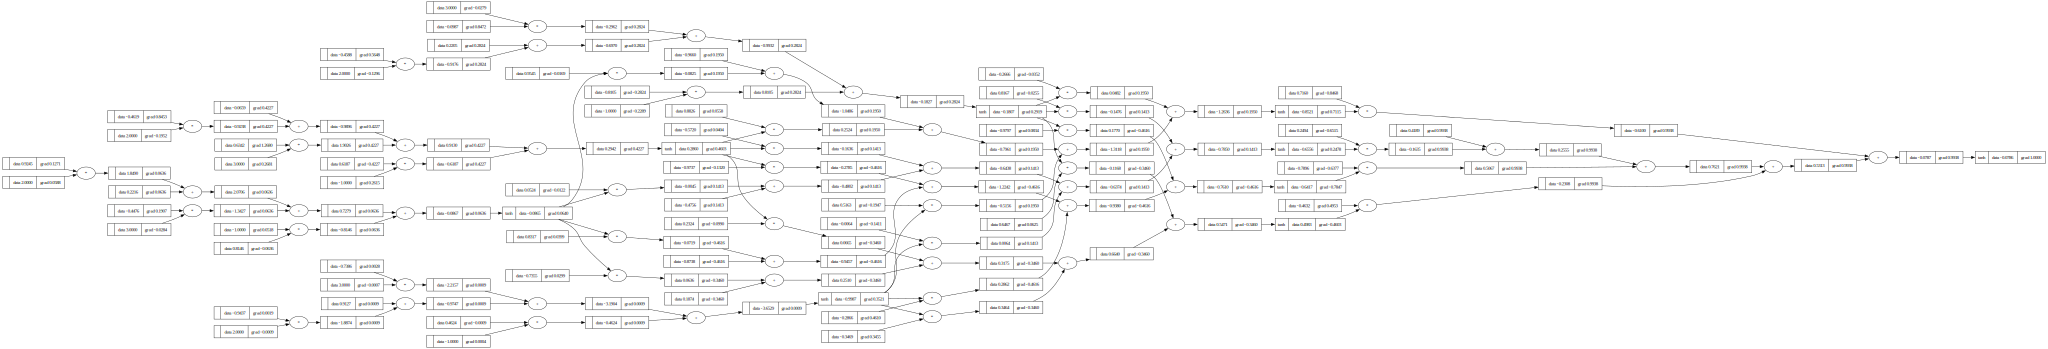

In [75]:
mlp = n(x)
mlp.grad = 1.0
mlp.backward()
draw_dot(mlp)

Check out how much more complex it gets, compared to what we started with. Wouldn't want to backpropagate over that with pen and paper! With `micrograd` we will be able to backpropagate through the entire expression and into the weights of the neurons. Let's see how that works.

## Creating a tiny dataset, writing the loss function [01:51:04](https://www.youtube.com/watch?v=VMj-3S1tku0&t=6664s)

How does a neural network learn? It basically minimizes an error function (a.k.a. _loss function_), using the gradients to tweak neuron weights. We've built pretty much all the infrastructure to go through a small example.

Let's start with the dataset. We define a set of inputs `xs` and a set of desired outputs `ys` with the goal of having our network output the correct `y`. It's basically a _binary classifier_ example: given an input feature vector, we want to categorize it into one of the two classes.

In [76]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.07858165176637057),
 Value(data=-0.5708475690009241),
 Value(data=0.8155559017952988),
 Value(data=-0.04923278403115345)]

How do we make our neural net predict numbers that are closer to expected values?

.

.

.

The trick is to define a single number that measures how well the entire network is performing. This is what the _loss function_ does. It tells us how _wrong_ the entire network is in making predictions. We want to make the network _less wrong_, ideally bringing loss function value down to zero.

There are different varieties of loss functions. We'll use the _Mean Squared Error (MSE)_ loss.

> **_MSE computational recipe_:** for each sample calculate how far a prediction `yout` is from the ground truth `ygt`, square that number to make sure it's always positive, sum individual errors over all samples to get the loss value for the entire network.

In [77]:
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss

TypeError: unsupported operand type(s) for +: 'int' and 'Value'

_Whoops, that's an error!_ Looks like we'll need to update the `Value` class to support reflected operand order for the `+` operation, just as we did with multiplication earlier in this tutorial.

> _**Note**_: `__radd__` method is one of the special methods that can be defined in a class to emulate numeric objects. It is called to implement the binary arithmetic operations (+) with reflected (swapped) operands. This method is only called if the left operand does not support the corresponding operation and the operands are of different types.

In [78]:
class Value:

  def __init__(self, data, children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # node gradient with respect to the loss function
    self._backward = lambda: None # the backpropagation delegate
    self._prev = set(children)
    self._op = _op
    self.label = label

  # This works akin to object.ToString() in C#
  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      # gradient accumulation
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out

  def __radd__(self, other):
    return self + other

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      # gradient accumulation
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __pow__(self, other):
    assert isinstance(other, (int, float)),\
     "only supporting int/float powers for now"

    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * self.data ** (other-1) * out.grad

    out._backward = _backward
    return out

  def __truediv__(self, other):
    # When you use the division operator (/) between two objects,
    # Python internally calls the __truediv__ method
    # of the left operand object and passes the right operand
    # object as an argument.
    # The __truediv__ method should return the result of the division.
    return self * other**-1

  def tanh(self):
    n = self.data
    tanh = (math.exp(2*n)-1)/(math.exp(2*n)+1)
    out = Value(tanh, (self,), label='tanh')
    def _backward():
      # gradient accumulation
      local_derivative = 0.0
      local_derivative += (1-tanh**2)
      self.grad = local_derivative * out.grad

    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      local_derivative = 1.0 if out.data == 0 else out.data
      self.grad += local_derivative * out.grad

    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)
    topo = list(reversed(topo))

    self.grad = 1.0
    for node in topo:
      node._backward()

`Value` type is changed and now we need to reevaluate `ypred`

In [79]:
ypred = [n(x) for x in xs]
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.744642856188994)

In [80]:
loss.backward()

What happened when we called the `backward` method? Each weight of each neuron now has its `grad` computed. It tells us about the impact of that weight on the loss function and the direction it should be tweaked in to reduce the loss.

In [81]:
n.layers[0].neurons[0].w[0].grad

0.1780745217539438

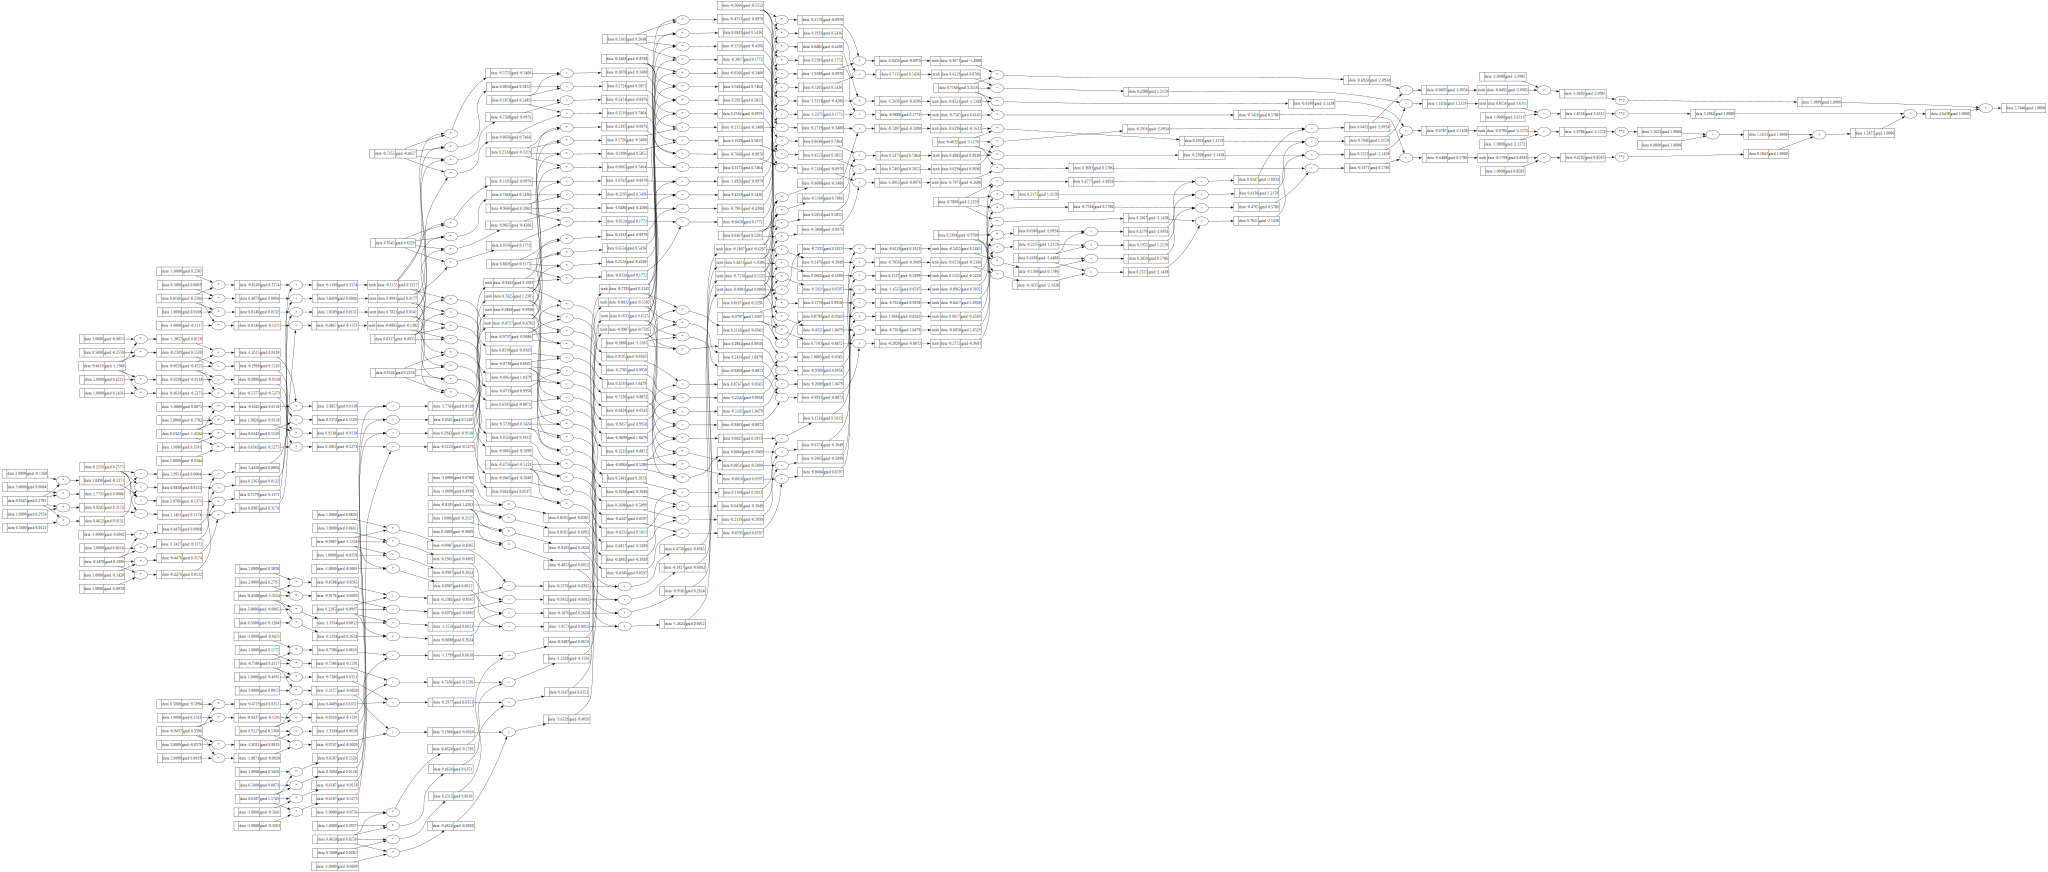

In [82]:
draw_dot(loss)

> _**Intuition**:_ Training the network is kinda like tweaking the radio knobs until you find the right station. You move weights up or down by using the gradient values until the loss approaches zero.

## Collecting all of the parameters of the neural net [01:57:56](https://www.youtube.com/watch?v=VMj-3S1tku0&t=7076s)

Time for some convenience code. We'll collect all the weights and biases for every neuron, so that we can nudge them in the right direction after every backward pass simultaneously. These are often called _network parameters_.

Following the `PyTorch` convention, we'll add a `parameters` method to our `Neuron`, `Layer` and `MLP` classes:

In [83]:
import random

class Neuron:

  def __init__(self, nin):
    """
      nin: number of inputs
    """
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w * x + b
    activation = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
    out = activation.tanh()

    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    # as a matter of convenience, unwrap the value
    # out of array if it's just a single value.
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sizes = [nin] + nouts
    self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)

    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [84]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

print(f"# Parameters: {len(n.parameters())}")
n.parameters()

# Parameters: 41


[Value(data=0.8731332201943414),
 Value(data=-0.5045066114292067),
 Value(data=-0.9947952157192688),
 Value(data=0.081825528865072),
 Value(data=-0.4575915024703092),
 Value(data=-0.47462391205779),
 Value(data=0.0740139160263904),
 Value(data=0.5712419672835487),
 Value(data=-0.7298516014832777),
 Value(data=-0.6419004576166338),
 Value(data=-0.3855494170108156),
 Value(data=0.29436237862274406),
 Value(data=-0.25195094683034536),
 Value(data=-0.7505384617503048),
 Value(data=-0.5534723773217263),
 Value(data=-0.5235577132289786),
 Value(data=-0.04767207318017119),
 Value(data=0.9786828425837959),
 Value(data=0.7287442277420557),
 Value(data=-0.7917899069285328),
 Value(data=0.806614340130507),
 Value(data=0.07762676359185394),
 Value(data=-0.15092018228066895),
 Value(data=0.01754398995093287),
 Value(data=0.3175574505724774),
 Value(data=-0.12024295283558084),
 Value(data=0.47775909874621636),
 Value(data=0.29585487364341256),
 Value(data=0.0950399146771006),
 Value(data=-0.17526541

## Doing gradient descent optimization manually, training the network [02:01:12](https://www.youtube.com/watch?v=VMj-3S1tku0&t=7272s)

_Gradient descent_ iteratively applies the _forward pass_, the _backward pass_ and _weight update step_ to minimize the _loss function_.

In _gradient descent_ we think about the gradient as of a vector pointing in the direction of increased loss. Since we want to minimize loss, at every gradient descent step we want to move in the opposite direction - _away from loss_ :) In numerical terms this means increasing a weight if its gradient is negative and decreasing it otherwise.

The training loop basically consists of three steps:

1. Forward pass: compute all the neuron values, given the input data;

2. Backward pass: Compute the gradients for each parameter;

3. Adjust weights and biases: Use gradient to nudge parameters in the right direction, away from maximum loss.



Go ahead and repeat these steps a few times to see how the loss is gradually decreased:

In [85]:
# Forward pass
ypred = [n(x) for x in xs]
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.9600267233152655)

In [86]:
# Backward pass
loss.backward()

In [87]:
# Adjust weights and biases
for p in n.parameters():
  p.data += -1 * 0.05 * p.grad

Let's wrap these steps into a training loop for convenience:

In [88]:
for i in range(0, 20):
  ypred = [n(x) for x in xs]
  loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
  loss.backward()
  for p in n.parameters():
    p.data += -1 * 0.05 * p.grad
  print(loss)


Value(data=5.253879288916136)
Value(data=4.104861661964056)
Value(data=3.511096958252616)
Value(data=2.070420508148862)
Value(data=0.36316222991207536)
Value(data=0.12208441355623381)
Value(data=0.02154474096452351)
Value(data=0.0021931382667584784)
Value(data=0.0003769871617512779)
Value(data=8.255379670906548e-05)
Value(data=1.8602441960811616e-05)
Value(data=4.132961172426251e-06)
Value(data=8.971956681636045e-07)
Value(data=2.0029049776610915e-07)
Value(data=5.881161001619777e-08)
Value(data=3.1875106917630774e-08)
Value(data=2.7624305664894782e-08)
Value(data=2.8681143809263003e-08)
Value(data=3.205914645079121e-08)
Value(data=3.7281722682367135e-08)


And we can see that the predicted values get pretty close to ground truth.

In [89]:
[n(x) for x in xs]

[Value(data=0.999999997409672),
 Value(data=-0.9999999315049053),
 Value(data=-0.999789503259131),
 Value(data=0.9999999255937848)]

> **_Note about the step size_**: Can't you just pick a big step size to make the neural net learn faster? Why do we use just `0.05`?
>
> Remember that at each step we are operating at a local point of the loss function curve. We don't really know its shape. It may be complicated. Picking an overly large step size would likely lead the network to overshoot. It's like _jumping to conclusions_ - updating your beliefs _too fast_, based on small and inconclusive hints.
>
> Should we make the learning rate much smaller? Not necessarily. Set it too small and your neural net will take too long to train. For large LLMs that means considerable unnecessary costs.
>
> So aim to set your learning rate to a value that's _about right_. In practice, it's a bit of an art done through trial-and-error. There are rules of thumb that Andrej touches in later lectures.

## _Gotcha!_ Fixing yet another common bug [02:10:23](https://youtu.be/VMj-3S1tku0?t=7823)

Our training loop code has a bug that's both subtle and common. It's a case of _you forgot to `zero_grad()`_ - essentially, we're not resetting the gradient on each training loop iteration and it keeps accumulating.

In [90]:
Image(url='https://miro.medium.com/v2/resize:fit:800/0*NUjEE5SqiyVCRvLR.png')

The interesting thing is that our network still converged. Why is that?

.

.

First, our network is very simple. Second, we got lucky. If we were training a network for a more difficult problem, most likely it wouldn't converge. Let's fix that.

In [91]:
n = MLP(3, [4, 4, 1]) # reset the network

In [92]:

for i in range(0, 20):
  # Reset gradients to zero.
  # We don't want to keep the gradients from previous iteration: we're now at a new point on the loss curve.
  for p in n.parameters():
    p.grad = 0.0

  ypred = [n(x) for x in xs]
  loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))


  loss.backward()
  for p in n.parameters():
    p.data += -1 * 0.05 * p.grad
  print(loss)


Value(data=5.493257660298013)
Value(data=3.897220044558149)
Value(data=3.120013518328281)
Value(data=2.5269364887999117)
Value(data=1.8273367631680661)
Value(data=1.1431496983287748)
Value(data=0.6730444587537172)
Value(data=0.4297223397954788)
Value(data=0.30538994577738904)
Value(data=0.23337288547818896)
Value(data=0.1870487561760622)
Value(data=0.15500176656755163)
Value(data=0.13164702634712866)
Value(data=0.11395001559031478)
Value(data=0.10012685504340257)
Value(data=0.08906359730694081)
Value(data=0.08003065232380167)
Value(data=0.07253132191176537)
Value(data=0.0662164436916914)
Value(data=0.06083384215791911)


That's it. Our `micrograd`-based neural network is complete!

# Summary of what we learned, how to go towards modern neural nets [02:14:03](https://www.youtube.com/watch?v=VMj-3S1tku0&t=8043s)

The key takeaways:

1. _Neural nets_ are mathematical expressions. They take _vectors of input data_ `x`, feed them forward through a _computational graph_ and into a non-linear function like `tanh` to compute the _loss function_. The _loss function_ measures accuracy of network predictions. Its value will be low when your network behaves well.

2. A _neuron_ is a node of the _computational graph_. It has its _weights_ and a _bias_ that determine how inputs are transformed.

3. A neural network is trained by iteratively computing _gradients_ of each node during the _backward pass_ to figure out how that impacts _loss_ of the entire network. These gradients are used to tweak the individual _weights_ and _biases_ in order to minimize the _loss function_. This optimization algorithm is called _gradient descent_.

We built a very small network with just `41` parameters. But you can build much larger networks with _billions_ of parameters. As the size of the network and training data goes up, neural networks start to show fascinating emergent properties and capacity to solve complex problems.

Now you have an intuitive understanding how neural networks work under the hood.

# Next steps

1. Go through the [micrograd library code](https://github.com/karpathy/micrograd) on Github [02:16:46](https://www.youtube.com/watch?v=VMj-3S1tku0&t=8206s). Most of the code should now be easy to recognize. It features a slightly more complicated demo example in [demo.ipynb](https://github.com/karpathy/micrograd/blob/master/demo.ipynb)

2. Complete these excercises on your own to test your knowledge: [micrograd_exercises.ipynb](https://colab.research.google.com/drive/1FPTx1RXtBfc4MaTkf7viZZD4U2F9gtKN?usp=sharing)

3. Have a look at how operations like `tanh` are [implemented in PyTorch](https://github.com/pytorch/pytorch/blob/main/aten/src/ATen/native/cpu/BinaryOpsKernel.cpp) and how new functions can be added like Lego blocks. [02:21:10](https://www.youtube.com/watch?v=VMj-3S1tku0&t=8470s)
